# IFT6269 - Homework 3 - EM and Gaussian mixtures

## Introduction

The file `EMGaussian.train` contains samples of data $\{x_n\}_{n=1}^N$ where $x_n \in \mathbb{R}^2$, with one datapoint per row. The goal of this exercise is to implement the K-Means and EM algorithms using $K=4$ components/clusters. 

In [ ]:
!wget http://www.iro.umontreal.ca/~slacoste/teaching/ift6269/A20/notes/hwk3data.zip
!unzip hwk3data.zip

import numpy as np
import matplotlib.pyplot as plt
import sys
from scipy.stats import multivariate_normal
plt.style.use('seaborn-white')

X_train = np.loadtxt("/content/hwk3data/EMGaussian.train")
X_test = np.loadtxt("/content/hwk3data/EMGaussian.test")

--2020-11-04 17:27:03--  http://www.iro.umontreal.ca/~slacoste/teaching/ift6269/A20/notes/hwk3data.zip
Resolving www.iro.umontreal.ca (www.iro.umontreal.ca)... 132.204.26.36
Connecting to www.iro.umontreal.ca (www.iro.umontreal.ca)|132.204.26.36|:80... failed: Connection timed out.
Retrying.

--2020-11-04 17:27:46--  (try: 2)  http://www.iro.umontreal.ca/~slacoste/teaching/ift6269/A20/notes/hwk3data.zip
Connecting to www.iro.umontreal.ca (www.iro.umontreal.ca)|132.204.26.36|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 7269 (7.1K) [application/zip]
Saving to: ‘hwk3data.zip.1’

hwk3data.zip.1      100%[===================>]   7.10K  --.-KB/s    in 0s      

2020-11-04 17:28:02 (546 MB/s) - ‘hwk3data.zip.1’ saved [7269/7269]

Archive:  hwk3data.zip
replace hwk3data/EMGaussian.test? [y]es, [n]o, [A]ll, [N]one, [r]ename: n
replace hwk3data/EMGaussian.train? [y]es, [n]o, [A]ll, [N]one, [r]ename: n


## Playground

You are allowed to add as many cells and functions as you wish in this section, but not allowed to change the signature (name and inputs) of the functions!

In [ ]:
# ---------------------------------------------------------------------------
#                       Code for plotting the results 
#                      ! DO NOT MODIFY THESE FUNCTIONS !
# ---------------------------------------------------------------------------

from matplotlib.patches import Ellipse
def plot_ellipse(ax, mu, sigma, alpha=1, color="k"):
    evals, evecs = np.linalg.eigh(sigma)
    x, y = evecs[:, 0]
    theta = np.degrees(np.arctan2(y, x))
    for factor in [1.5, 3]:
        w, h = factor * np.sqrt(evals)
        ellipse = Ellipse(mu, w, h, theta, facecolor='none', edgecolor=color) 
        ellipse.set_alpha(alpha)
        ax.add_artist(ellipse) 
        
def show_kmeans(X_train, X_test, KM_centroids, KM_predictor):
    
    shapes = ['o', '*', 'v', '+']
    colors = ['#1f77b4', '#ff7f0e', '#2ca02c', '#9467bd', '#8c564b',
              '#e377c2', '#7f7f7f', '#bcbd22']
    
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 4))
    
    for (ax, data, title) in [(ax1, X_train, 'Training Set'), (ax2, X_test, 'Test Set')]:
        pred_labels, obj = KM_predictor(data)
        print("K-Means Objective on " + title + ": ", obj)
        cs = [colors[int(_) % len(colors)] for _ in pred_labels]
        ax.scatter(data[:, 0], data[:, 1], alpha=0.5, c=cs)
        ax.scatter(KM_centroids[:, 0], KM_centroids[:, 1], marker='o', c='#d62728')
        ax.set_title(title)
        ax.set_xlim(-12, 12), ax.set_ylim(-12, 12)
        ax.set_aspect('equal')    
        
    plt.show()
    print('\n')
    
    
def show_mog(X_train, X_test, MoG_pi, MoG_centroids, MoG_sigmas, MoG_predictor):
    
    shapes = ['o', '*', 'v', '+']  
    colors = [[31, 119, 180], [255, 127, 14], [44, 160, 44], [148, 103, 189],
             [140, 86, 75], [227, 119, 194], [127, 127, 127], [188, 189, 34]]
    
    max_pi = np.max(MoG_pi)
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 4))
    
    for (ax, data, title) in [(ax1, X_train, 'Training Set'), (ax2, X_test, 'Test Set')]:
        pred_labels, norm_llike = MoG_predictor(data)
        print("MoG Normalized Log-Likelihood " + title + ": ", norm_llike)
        cs = [colors[int(_) % len(colors)] + [0.5*255*MoG_pi[_]/max_pi] for _ in pred_labels]
        ax.scatter(data[:, 0], data[:, 1], c=np.array(cs)/255.)
        ax.scatter(MoG_centroids[:, 0], MoG_centroids[:, 1], marker='o', c='#d62728')
        ax.set_title(title)
        ax.set_xlim(-12, 12), ax.set_ylim(-12, 12)
        ax.set_aspect('equal')    
        
        for _ in range(MoG_pi.shape[0]):
            plot_ellipse(ax, MoG_centroids[_, :], MoG_sigmas[_, :,:], alpha=MoG_pi[_]/max_pi, color='k')
    
    plt.show()
    print('\n')

In [ ]:
def KMeans_init_plus(X, K): 
    centroids = [] 
    centroids.append(X[np.random.randint( 
            X.shape[0]), :]) 
    for c_id in range(K - 1): 
        dist = [] 
        for i in range(X.shape[0]):   
            d= sys.maxsize            
            for j in range(len(centroids)): 
                temp_dist = np.linalg.norm(X[i] - centroids[j])
                d = min(d, temp_dist)
            dist.append(d)    
        dist = np.array(dist) 
        next_centroid = X[np.argmax(dist), :] 
        centroids.append(next_centroid) 
        dist = [] 
    return np.array(centroids) 

In [ ]:
def KMeans(X, K=1):
    """
    Estimates the parameters of a K-means model using training data X
        
        Inputs:
            X: [nx2] matrix of inputs
            K: [int] number of clusters to use
            
        Returns:
            centroids: [Kx2] matrix of estimated centroid locations
            KMeans_predictor: function taking a matrix inX and returning the
                 predicted cluster number (starting from 0 to K-1) for each row 
                 of inX; and the normalized log-likelihood (i.e., divided by the
                 number of rows of inX).
                 
    """
    centroids = KMeans_init_plus(X,K)
    centroids_old = np.zeros_like(centroids)
    
    while not (centroids_old == centroids).all():
        z = np.zeros(shape=(X.shape[0], K))
        for i in range(X.shape[0]):
            cluster = np.argmin(np.linalg.norm(X[i] - centroids, axis=1))
            z[i,cluster] = 1
        
        centroids_old = centroids.copy()
        for i in range(K):
            centroids[i] = (z[:,i][:,np.newaxis]*X).sum(axis=0) / (z[:,i]).sum(axis=0)
            
    def KMeans_predictor(inX):
        """
        # TODO: use parameters from above to predict cluster for each row of inX
        
            Inputs:
                inX: [mx2] matrix of inputs
                
            Returns:
                pred_labels: [m] array of predicted cluster labels
                norm_loss: K-Means loss on inX, divided by the number of rows of inX
        """
        pred_labels = np.zeros((inX.shape[0]))
        for i in range(inX.shape[0]):
            pred_labels[i] = np.argmin(np.linalg.norm(inX[i] - centroids, axis=1))

        pred_labels = pred_labels.astype(int)

        norm_loss = np.sum(np.linalg.norm(inX - centroids[pred_labels], axis=1)**2)  / inX.shape[0]
        
        return pred_labels, norm_loss
    
    return centroids, KMeans_predictor

def GaussianMixture(X, K=1, use_full_cov=True):
    """
    Estimates the parameters of a Gaussian mixture model using training data X
    
    **Important:** The locations of the centroids must be initialized using your 
    K-Means code! With this information, initialize the proportions and variances
    accordingly.
    
        Inputs:
            X: [nx2] matrix of inputs
            K: [int] number of mixture components to use
            use_full_cov: [bool] if True, estimate a full covariance for each 
                mixture component. Else, we use a scaled identity for each 
                component (in this case each component might have a 
                different scaling of the identity: Sigma_i = sigma_i * I).
            
        Returns:
            pi: [K] vector of proportion of each class
            centroids: [Kx2] matrix of estimated centroid locations
            sigmas: [Kx2x2] tensor of estimated covariance matrices
            MoG_predictor: function taking a matrix inX and returning the
                 predicted cluster number (starting from 0 to K-1) for each row 
                 of inX; and the normalized log-likelihood (i.e., divided by the
                 number of rows of inX).
    """
    
    # Initialize centroids using KMeans
    centroids, _ = KMeans(X, K)
    
    if use_full_cov:
        # We use a full covariance for each class
        sigmas = np.concatenate(K*[np.cov(X_train.T)[np.newaxis, ...]], axis=0)
    else:
        # We use one scaled identity for each class
        sigmak2 = np.ones(K) # These are the sigma^2_k for k=1, ..., K
        s = np.diag(np.cov(X_train.T))
        sigmas = np.concatenate([sigmak2[_] * (s * np.eye(2))[np.newaxis, ...] for _ in range(K)], axis=0)
        # Careful! We expect to return the covariance matrix. Don't mix these up!

    z = np.zeros(shape=(X.shape[0], K))
    for i in range(X.shape[0]):
        cluster = np.argmin(np.linalg.norm(X[i] - centroids, axis=1))
        z[i,cluster] = 1
    pi = np.sum(z, axis=0) / X.shape[0]

    predict = np.random.randint(0, K, size=(X.shape[0]))
    predict_old = np.zeros_like(predict)

    mu = centroids
    sigma_2 = sigmas
    
    while not all(predict == predict_old):
        # E step
        likelihood = np.zeros( (X.shape[0], K) )
        for i in range(K):
            likelihood[:,i] = multivariate_normal(mean = mu[i], cov = sigma_2[i]).pdf(X)
        
        numerator = likelihood * pi
        denominator = numerator.sum(axis=1)[:, np.newaxis]
        tau = numerator / denominator
        
        predict_old = predict.copy()
        
        # M step: Compute mu, sigma_2, pi
        pi = tau.mean(axis=0)
                
        for j in range(K):
            weight = tau[:, j]
            total_weight = weight.sum()
            mu[j] = (X * weight[:,np.newaxis]).sum(axis=0) / total_weight

            if use_full_cov == False:
                s = (weight[:,np.newaxis] * (X - mu[j])).T.dot(X - mu[j])
                sigma_2[j] = np.diag(s / total_weight) * np.identity(X.shape[1])
            else:
                s = (weight[:,np.newaxis] * (X - mu[j])).T.dot(X - mu[j])
                sigma_2[j] = s / total_weight
            
        likelihood = np.zeros((X.shape[0], K))
        for j in range(K):
            likelihood[:,j] = multivariate_normal(mean = mu[j], cov = sigma_2[j]).pdf(X)
        
        numerator = likelihood * pi
        predict = np.argmax(numerator, axis=1)

    sigmas = sigma_2
    centroids = mu

    def MoG_predictor(inX):
        """
        # TODO: use parameters from above to predict cluster for each row of inX
        
            Inputs:
                inX: [mx2] matrix of inputs
                
            Returns:
                pred_labels: [m] array of predicted cluster labels
                norm_loglike: (lower bound on) the log-likelihood for inX  divided
                    by the number of rows of inX
        """
         
        likelihood = np.zeros((inX.shape[0], K))
        for i in range(K):
          likelihood[:,i] = multivariate_normal(mean = centroids[i], cov = sigmas[i]).pdf(inX)
        
        numerator = likelihood * pi
        denominator = numerator.sum(axis=1)[:, np.newaxis]
        tau = numerator / denominator
    
        pred_labels = np.argmax(tau, axis=1)
        norm_loglike = (tau * np.log(numerator)).flatten().sum()/inX.shape[0]
        
        return pred_labels, norm_loglike
    
    return pi, centroids, sigmas, MoG_predictor    

## Model Comparison

In this section **DO NOT** change the code in any of the cells. Simply answer the questions in the corresponding text cells after having executed your implementation. If you have respected the signature of the functions above in terms of inputs and outputs, your code should run. 

### K-Means


K-Means Objective on Training Set:  6.475559192992271
K-Means Objective on Test Set:  6.226942004780743


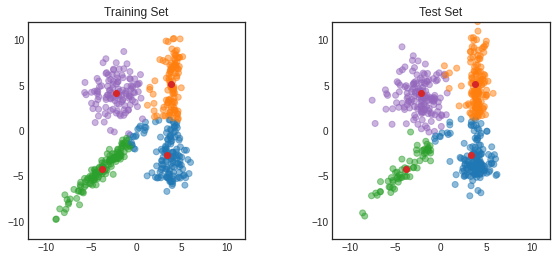



K-Means Objective on Training Set:  6.475559192992271
K-Means Objective on Test Set:  6.226942004780743


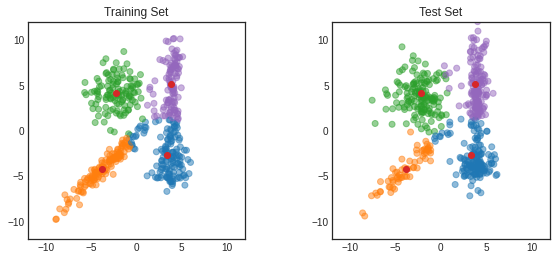



K-Means Objective on Training Set:  6.482445898056443
K-Means Objective on Test Set:  6.149834718502425


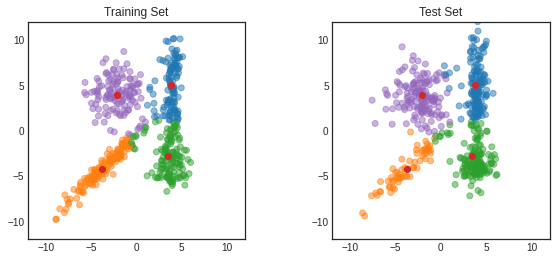

In [ ]:
for run in range(3):
    KM_centroids, KM_predictor = KMeans(X_train, K=4)
    show_kmeans(X_train, X_test, KM_centroids, KM_predictor)

We have trained your implementation of the K-Means algorithm using `X_train` for 3 different initializations. 

**Question:** Briefly compare the results above in terms of the location of the centers and the K-means training objective (at convergence) across runs with different initializations. What conclusions can you draw from this? 

**Answer:** The results at the end are not always the same, it was stated in class that the convergence of KMeans is local and hence affected by the initialization, we used KMeans++ initialization method that is guaranteed to find a solution that is O(log k) competitive to the optimal k-means solution, we see that the different solutions are roughly the same (1 and 2 are the same) which confirms our claim.

### EM for Gaussian mixture models 

Scaled identity covariance matrices
MoG Normalized Log-Likelihood Training Set:  -5.182692613468962
MoG Normalized Log-Likelihood Test Set:  -5.062204488681347


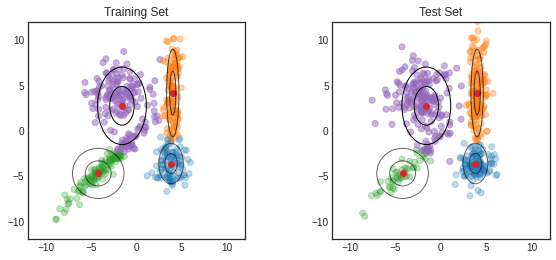




Full covariance matrices
MoG Normalized Log-Likelihood Training Set:  -4.734817734216649
MoG Normalized Log-Likelihood Test Set:  -4.900764318553411


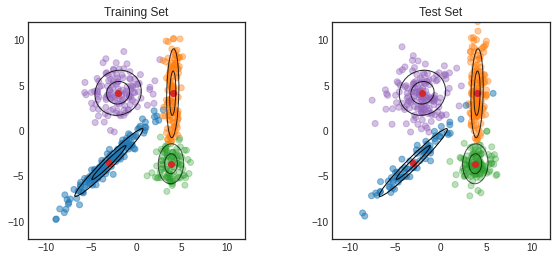

In [ ]:
print('Scaled identity covariance matrices')
MoG1 = GaussianMixture(X_train, K=4, use_full_cov=False)
show_mog(X_train, X_test, MoG1[0], MoG1[1], MoG1[2], MoG1[3])

print('\nFull covariance matrices')
MoG2 = GaussianMixture(X_train, K=4, use_full_cov=True)
show_mog(X_train, X_test, MoG2[0], MoG2[1], MoG2[2], MoG2[3])

We have trained your implementation of the EM algorithm for a Gaussian mixture model using `X_train`. The plots show the behavior on the training and testing (left and right) sets when using scaled diagonal or full covariance matrices (top and bottom), respectively. 

**Question:** Briefly compare the results above in terms of the location of the centers and the normalized log-likelihood between the training and test set. What conclusions can you draw from this? 

**Answer:** Comparing the plots, the means are in just slightly different positions but the bigger difference is in the shape of the covariances in the above 2 plots the covariances are symmetric so there is somehow a restriction especially in the green class where we require a non symmetric covariance and I believe it is what made the difference in the Log-Likelihood value.

### Bonus
**Question:** From your observations on the K-Means and EM sections, is there any relation one can stablish between these two methods? f so, how do the plots above reflect this?  

**Answer:** As stated in class and in the scribe notes, KMeans is a special case of EM, we can  get it by executing EM with fixed diagonal covariance matrices proportional to the identity matrix; $\Sigma_j = \sigma^2I$ with $\sigma^2 \rightarrow 0$. The reflection in the plots can't be seen directly but roughly KMeans assume a spherical and identical covariance for all the classes which is different from EM.